# Random forest regression

In this Jupyter Notebook an example of [Random Forest Regressor](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html), the machine learning model, will be presented. The Random Forest Regression algorithm will be applied to energy time series data. When the model has to analyse very large datasets, it can take more time to train the data.
The following Python (3.10) libraries were used:
pandas, scikit-learn, matplotlib, and seaborn. The notebook is divided in 4 sections:
1. load the desired data,
2. conduct exploratory data analysis,
3. create the Random Forest Regression model,
4. predict the net position of the given portfolio.

In [2]:
import os
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score, mean_absolute_error, root_mean_squared_error
from sklearn.ensemble import RandomForestRegressor

from IPython.display import Image

## Load the desired data
The given data are stored in a json file. The sample data look like \
\[ \
&ensp;{ \
&emsp;"ID": "123", \
&emsp;"timestamp": "2023-01-01T07:00:00Z", \
&emsp;"received": 0, \
&emsp;"sent": 123 \
&ensp;}, \
&ensp;{ \
&emsp;"ID": "456", \
&emsp;"timestamp": "2023-01-01T08:00:00Z", \
&emsp;"received": 0, \
&emsp;"sent": 456 \
&ensp;}, \
&ensp;{ \
&emsp;"ID": "789", \
&emsp;"timestamp": "2023-01-01T09:00:00Z", \
&emsp;"received": 0, \
&emsp;"sent": 789 \
&ensp;} \
\].

In [ ]:
data_file = "energy_readings.json"
directory = os.path.abspath(os.path.dirname(__file__))

def load_data(data_file, directory):
    """
    load data into a dataframe
    """
    for i in os.listdir(directory):
        if i == data_file:
            file_path = os.path.join(directory, data_file)       
    data_df = pd.read_json(file_path, encoding = 'utf-8-sig')
    
    data_df['timestamp'] = pd.to_datetime(data_df['timestamp']).dt.tz_convert('Europe/Berlin') # CET = UTC + 1h
    data_df = data_df.sort_values(by='timestamp').reset_index(drop=True)
    data_df['year'] = data_df.timestamp.dt.year
    data_df['month'] = data_df.timestamp.dt.month
    data_df['day'] = data_df.timestamp.dt.day
    data_df['hour'] = data_df.timestamp.dt.hour
    data_df['net'] = data_df['sent'] - data_df['received']
    return data_df

data_df = load_data(data_file, directory)

## Conduct exploratory data analysis

In the summary is displayed descriptive statistics and first ten and last ten rows of a dataset. The [correlation matrix](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.corr.html) can be calculated as well. In this example, information about the number of clients (ID) does not play any role.

In [ ]:
# print('Info: \n', data_df.info())
print('Summary: \n', data_df.describe())
print('First rows: \n', data_df.head(10))
print('Last rows: \n', data_df.tail(10))

no_value = data_df.isnull().values.any()
# print('Any nulls in a dataset: ', no_value)
client = data_df['ID'].nunique()
# print('Number of clients: ', client)
year = data_df['timestamp'].dt.year.unique()
# print('Years: ', year)

corr_ = data_df.sent.corr(data_df.received)
# print('Correlation: ', corr_)
corr_s = data_df.net.corr(data_df.sent)
# print('Correlation between net and sent: ', corr_s)
corr_r = data_df.net.corr(data_df.received)
# print('Correlation between net and received: ', corr_r)

sns.heatmap(data_df[['received', 'sent', 'net']].corr(), cmap='Reds', annot=True).set_title('Correlation Matrix')
plt.show()

matplotlib.rcParams['agg.path.chunksize'] = 10000
matplotlib.rcParams['font.size'] = 14
sns.set_theme(style='darkgrid')
fig1, (ax1, ax2) = plt.subplots(ncols=2, figsize=(15, 5))
sns.lineplot(data=data_df, x="timestamp", y="received", ax=ax1)
ax1.set_ylim(0, 80)
ax1.set_title('Time series of received')
ax1.set_xlabel('Time [CET]'); 
ax1.set_ylabel('Energy [kWh]')

sns.lineplot(data=data_df, x="timestamp", y="sent", ax=ax2)
ax2.set_ylim(0, 300)
ax2.set_title('Time series of sent')
ax2.set_xlabel('Time [CET]');
ax2.set_ylabel('Energy [kWh]')
plt.tight_layout()
fig1.savefig(directory + '/TS_received_sent.png')

fig3, ax3 = plt.subplots(1, 1, figsize = (16, 8))
sns.lineplot(data=data_df, x="timestamp", y="net")
ax3.set_ylim(-50, 200)
ax3.set_title('Time series of net')
ax3.set_xlabel('Time [CET]');
ax3.set_ylabel('Energy [kWh]')
fig3.savefig(directory + '/TS_net.png')

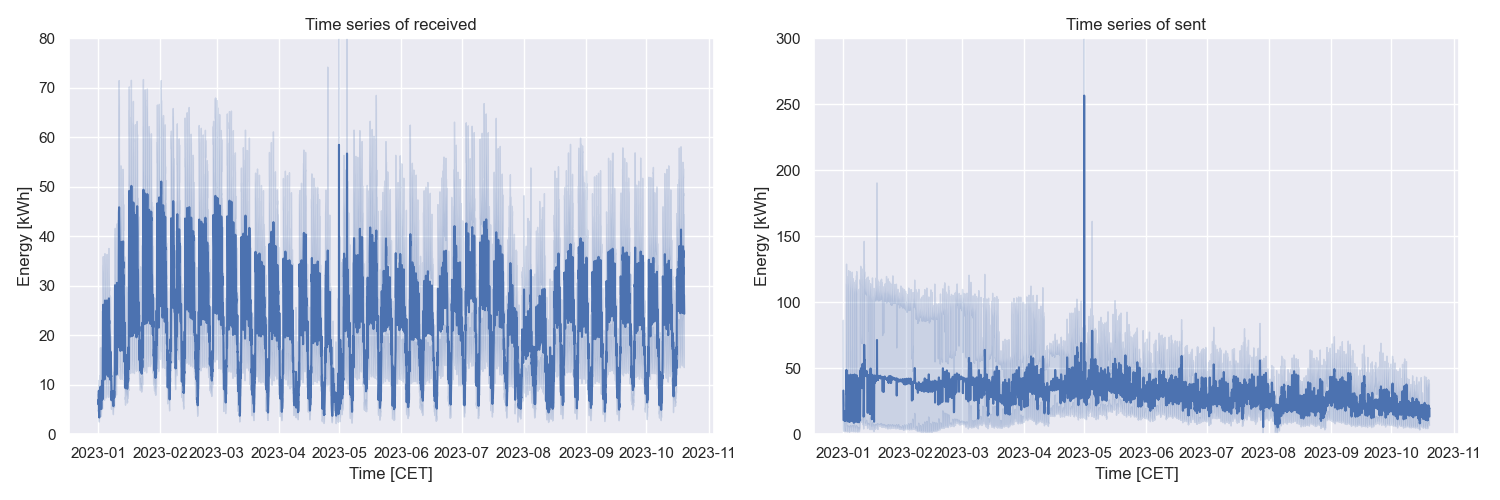

In [3]:
Image("TS_received_sent.png")

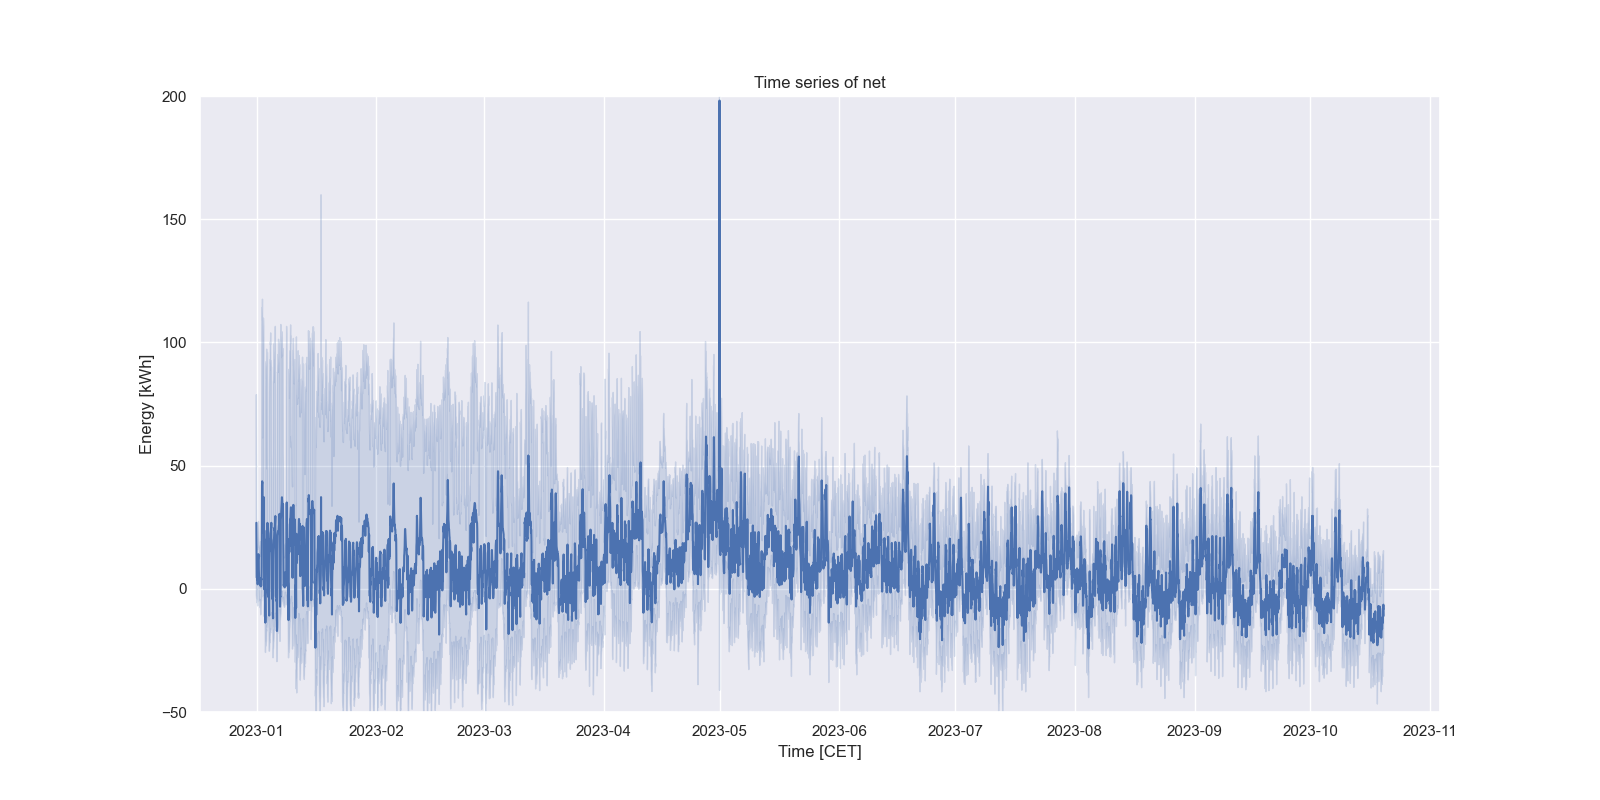

In [4]:
Image("TS_net.png")

## Create the Random Forest Regression model

The scaling function uses the [MinMaxScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html) estimator
$$
x_{scaled} = \frac{x - x_{min}}{x_{max} - x_{min}}
$$
in order to transform the input variables into the \[0, 1\] range. It is recommended to normalize the input variables if they are measured at different scales. This has to be done prior to model fitting.

In [ ]:
def scaling(data_df):
    """
    scale values from 0 and 1
    """
    scaler = MinMaxScaler()
    scaler.fit(data_df[['received', 'sent', 'net']])
    data_df_sc = scaler.transform(data_df[['received', 'sent', 'net']])
    data_df_sc = pd.DataFrame(data_df_sc, columns=['received', 'sent', 'net'])
    
    data_df_sc['year'] = data_df['year']
    data_df_sc['month'] = data_df['month']
    data_df_sc['day'] = data_df['day']
    data_df_sc['hour'] = data_df['hour']
    return data_df_sc

data_df_sc = scaling(data_df)  
train_input = data_df_sc[['year', 'month', 'day', 'hour', 'received', 'sent']]
train_target = data_df_sc['net']

def model(train_input, train_target, directory):
    """
    Random Forest Regression model
    """
    x_train, x_test, y_train, y_test = train_test_split(train_input, train_target, test_size=0.2, random_state=0)
    
    regressor = RandomForestRegressor(n_estimators=10, random_state=42)
    regressor.fit(x_train, y_train)
    y_train_predict = regressor.predict(x_train)

    # print('R^2: ', r2_score(y_train, y_train_predict))
    # print('MAE: ', mean_absolute_error(y_train, y_train_predict))  
    # print('RMSE: ', root_mean_squared_error(y_train, y_train_predict))

    y_test_predict = regressor.predict(x_test)
    print('R^2_test: ', r2_score(y_test, y_test_predict))
    print('MAE_test: ', mean_absolute_error(y_test, y_test_predict))  
    print('RMSE_test: ', root_mean_squared_error(y_test, y_test_predict))

    x_test['timestamp_'] = pd.to_datetime(x_test['year'].map(str) + '-' +
                                          x_test['month'].map(str) + '-' +
                                          x_test['day'].map(str) + ' ' +
                                          x_test['hour'].map(str) +
                                          ':00:00', format='%Y-%m-%d %X')

    fig4, ax4 = plt.subplots(1, 1, figsize = (16, 8))
    plt.scatter(x_test['timestamp_'].to_numpy(), y_test.to_numpy(), s=5, c='r')
    plt.scatter(x_test['timestamp_'].to_numpy(), y_test_predict, s=5, c='b')
    ax4.set_xlim(x_test['timestamp_'].min(), x_test['timestamp_'].max())
    ax4.set_title('Random Forest Regression')
    ax4.set_ylabel('Net energy')
    ax4.set_xlabel('Time [CET]')
    ax4.legend(['truth', 'forecast'])
    fig4.savefig(directory + '/RandomForestRegression.png')
    return regressor

regressor = model(train_input, train_target, directory)

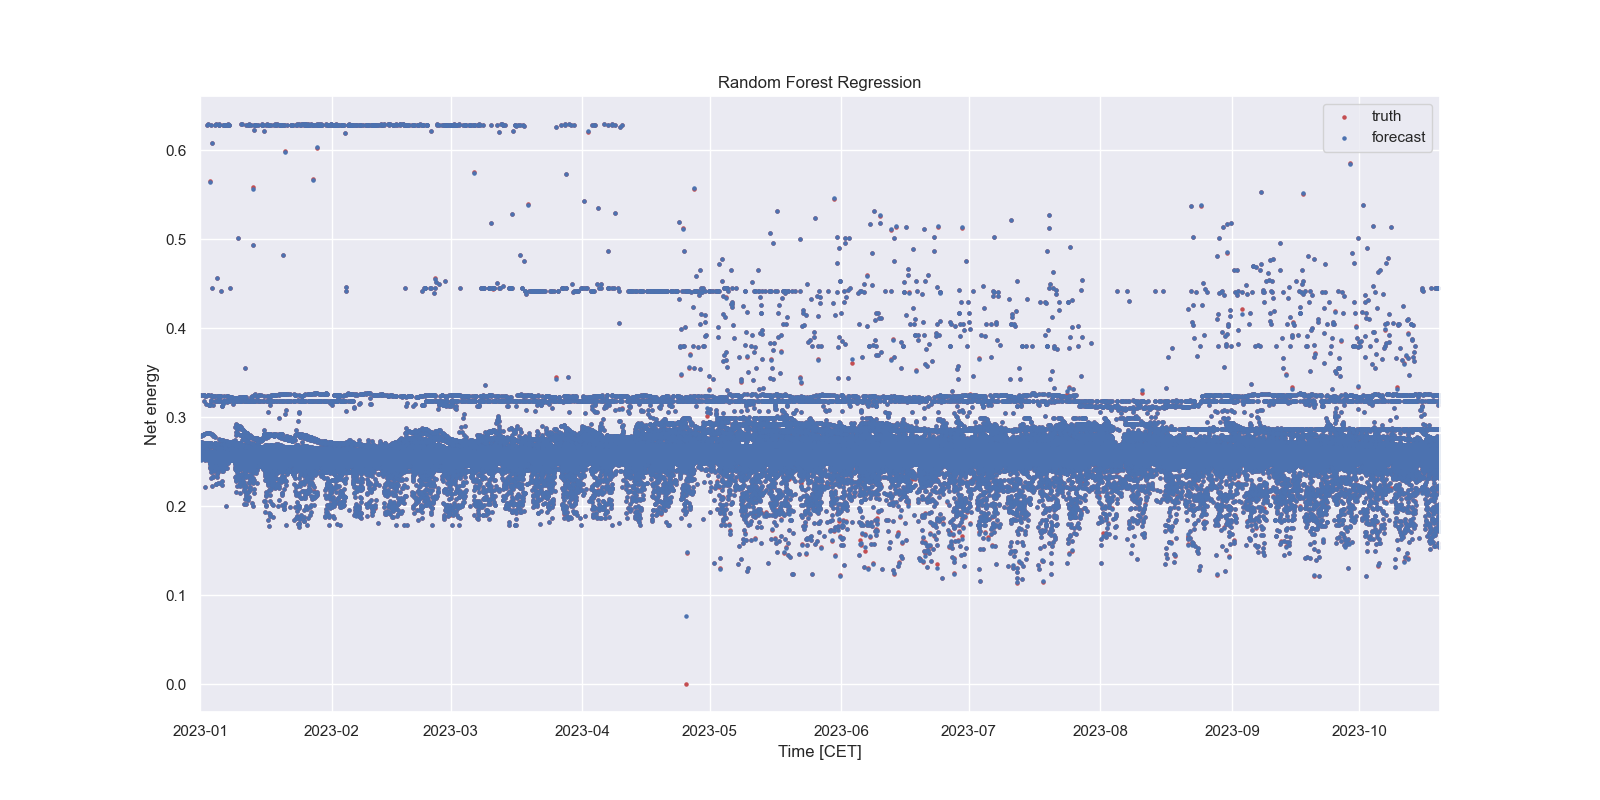

In [5]:
Image("RandomForestRegression.png")

In the above figure one can see that the model accurately predict the actual values.

## Predict the net position of the given portfolio

The trained model will be used to predict the net position of the portfolio for a selected date and time.

In [ ]:
def forecasting(data_df, regressor):
    """
    prediction of the net position of the portfolio for 2023-10-25 08:00:00
    """
    input_df = pd.DataFrame([new_input])
    y_predict = regressor.predict(input_df)
    # print('Scaled net energy', y_predict[0])
    net_predict = data_df['net'].min() + y_predict * (data_df['net'].max() - data_df['net'].min()) 
    net_ = net_predict[0]
    return net_

new_input = {'year' : 2023,
             'month' : 10,
             'day' : 25,
             'hour' : 8,
             'received' : train_input.loc[(train_input['month'] == 10) & (train_input['hour'] == 8), 'received'].mean(),
             'sent' : train_input.loc[(train_input['month'] == 10) & (train_input['hour'] == 8), 'sent'].mean()}
net_ = forecasting(new_input, data_df, regressor)
print('Net energy [kWh]: ', net_)